In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import hmmlearn.hmm as hmm
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

sys.path.append('../../')

from preprocessing import get_mfcc

from utils import  get_all_words, get_word

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Params

In [2]:
all_words = get_all_words(tiny=True)
class_names = [all_words[15], all_words[33], all_words[49]]

In [3]:
class_names

['to', 'co', 'o']

In [4]:
# states = [4, 4, 3]
# n_mixs = [7, 7, 6]

states = [2, 2, 3]
n_mixs = [4, 5, 3]
k_fold = 5

In [5]:
states

[2, 2, 3]

In [6]:
dataset_path = '../../../datasets/split'

In [7]:
def load_data_kfold(dataset_path: str, class_names: list, k: int):
    """
    Chia dữ liệu thành k-fold cross-validation, mỗi fold có cấu trúc như yêu cầu.

    Args:
        dataset_path (str): Đường dẫn tới tập dữ liệu.
        class_names (list): Danh sách tên các lớp.
        k (int): Số lượng folds trong k-fold cross-validation.

    Returns:
        folds (list): Danh sách k folds, mỗi fold có dạng:
                      {'train': {'class1': [...], 'class2': [...]},
                       'test': {'class1': [...], 'class2': [...]}}.
    """
    # Tổng hợp dữ liệu và nhãn cho từng lớp
    all_data = {cname: [] for cname in class_names}

    for cname in class_names:
        file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
            os.path.join(dataset_path, cname)) if i.endswith('.wav')]
        
        # Tính MFCC cho mỗi file và lưu vào all_data
        all_data[cname] = [get_mfcc(file_path) for file_path in file_paths]

    # KFold cho mỗi lớp và tạo danh sách các fold
    X_folds = []
    y_folds = []

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Duyệt qua các fold
    for fold_idx in range(k):
        X_fold = {'train': {cname: [] for cname in class_names},
                'test': {cname: [] for cname in class_names}}
        
        y_fold = {'train': {cname: [] for cname in class_names},
                'test': {cname: [] for cname in class_names}}
        
        label = 0

        for cname in class_names:
            data = all_data[cname]
            splits = list(kf.split(data))

            train_indices, test_indices = splits[fold_idx]

            # Lưu dữ liệu huấn luyện và kiểm thử
            X_fold['train'][cname] = [data[i] for i in train_indices]
            X_fold['test'][cname] = [data[i] for i in test_indices]

            y_fold['train'][cname] = [label] * len(train_indices)
            y_fold['test'][cname] = [label] * len(test_indices)

            label += 1

        X_folds.append(X_fold)
        y_folds.append(y_fold)

    return X_folds, y_folds

In [8]:
X_folds, y_folds = load_data_kfold(dataset_path, class_names, k_fold)

In [9]:
def train(X: dict[str, dict], class_names: list[str], states: list[int], n_mixs):
    models = {}
    likelihoods = {}

    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0
        trans_matrix = trans_matrix / (states[idx])

        # trans matrix
        # print(cname)
        # print(trans_matrix)
        
        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            n_mix=n_mixs[idx],
            verbose=False,
            n_iter=300,
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            params='stmc',
            init_params='mc',
            random_state=42
        )

        models[cname].fit(X=np.vstack(X['train'][cname]),
                                lengths=[x.shape[0] for x in X['train'][cname]])

        likelihoods[cname] = models[cname].monitor_.history

    return models, likelihoods


In [10]:
def show_prob(models: dict[str, hmm.GMMHMM], class_names: list[str]):
    for cname in class_names:
        print("\nMa trận chuyển tiếp trạng thái ẩn của \"" + cname +"\":")
        print(models[cname].transmat_)

In [11]:
def evaluation(model: dict, X: dict[str, dict], y: dict[str, dict], class_names: list[str]):
    y_true = []
    y_pred = []

    # Duyệt qua từng lớp
    for cname in class_names:
        true_for_class = []
        pred_for_class = []

        # Duyệt qua từng mẫu của lớp
        for mfcc, target in zip(X['test'][cname], y['test'][cname]):
            try:
                # Tính điểm số cho mỗi lớp
                scores = [model[c].score(mfcc) for c in class_names]
                pred = np.argmax(scores)

                # Lưu kết quả dự đoán và nhãn thực tế
                true_for_class.append(target)
                pred_for_class.append(pred)
            except Exception as e:
                print(f"Error processing sample for class {cname}: {e}")

        # Cập nhật vào danh sách chung
        y_true.extend(true_for_class)
        y_pred.extend(pred_for_class)

    return y_true, y_pred

In [12]:
from itertools import product

In [13]:
# # Các giá trị của states và n_mixs
# state_values = range(2, 5)
# mix_values = range(3, 6)

# # Sinh tất cả các tổ hợp có thể cho states và n_mixs
# state_combinations = list(product(state_values, repeat=3))
# mix_combinations = list(product(mix_values, repeat=3))

# # Vòng lặp chính
# for states in state_combinations:
#     for n_mixs in mix_combinations:
#         all_y_true = []
#         all_y_pred = []
#         overall_acc_avg = 0.0

#         for i in range(k_fold):
#             # Huấn luyện mô hình cho từng fold
#             models, likelihoods = train(X_folds[i], class_names, states, n_mixs)

#             # Đánh giá mô hình
#             y_true, y_pred = evaluation(models, X_folds[i], y_folds[i], class_names)
            
#             # Tổng hợp nhãn dự đoán và thực tế
#             all_y_true.extend(y_true)
#             all_y_pred.extend(y_pred)
            
#             # Accuracy cho fold hiện tại
#             fold_acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
#             overall_acc_avg += fold_acc

#         # Accuracy tổng thể
#         overall_acc_avg /= k_fold

#         # Tính ma trận nhầm lẫn tổng thể
#         cm = confusion_matrix(all_y_true, all_y_pred, labels=range(len(class_names)))

#         print(f'Overall accuracy with {states} states and {n_mixs} mixtures: {overall_acc_avg}')
#         # save result to file txt
#         with open('result.txt', 'a') as f:
#             f.write(f'Overall accuracy with {states} states and {n_mixs} mixtures: {overall_acc_avg}\n')

Training: 100%|██████████| 5/5 [00:25<00:00,  5.13s/it]


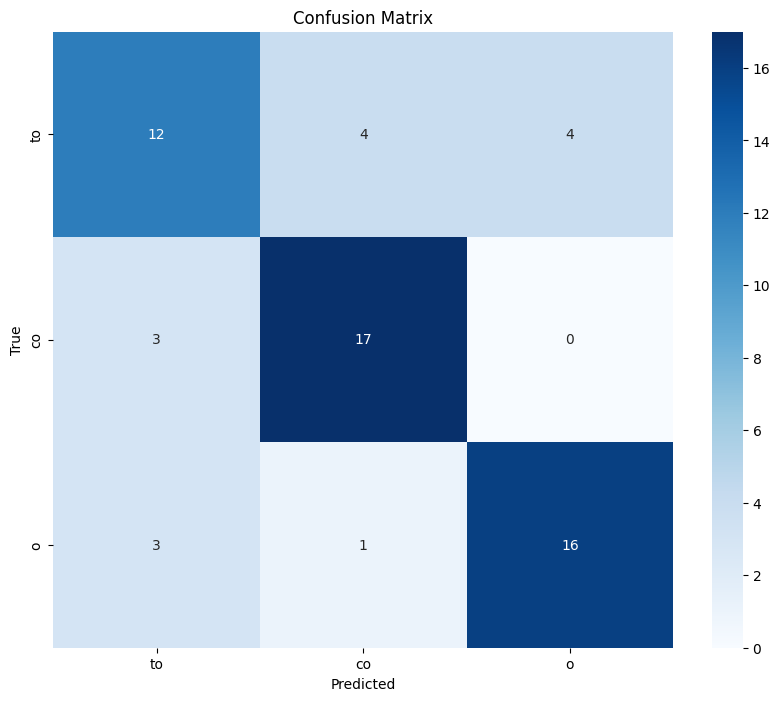

Overall accuracy: 0.75


In [14]:
all_y_true = []
all_y_pred = []
overall_acc_avg = 0.0

for i in tqdm(range(k_fold), desc='Training', position=0):
    # Huấn luyện mô hình cho từng fold
    models, likelihoods = train(X_folds[i], class_names, states, n_mixs)

    # Đánh giá mô hình
    y_true, y_pred = evaluation(models, X_folds[i], y_folds[i], class_names)
    
    # Tổng hợp nhãn dự đoán và thực tế
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    
    # Accuracy cho fold hiện tại
    fold_acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    overall_acc_avg += fold_acc

# Accuracy tổng thể
overall_acc_avg /= k_fold

# Tính ma trận nhầm lẫn tổng thể
cm = confusion_matrix(all_y_true, all_y_pred, labels=range(len(class_names)))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Overall accuracy: {overall_acc_avg:.2f}')